In [2]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/" # a download-only linked
HOUSING_PATH = os.path.join("datasets","housing") # Defines a path in the folder where I'm currently working in
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz" # defining the saving and extraction path
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH): # defining function to extract and save housing data
    os.makedirs(housing_path, exist_ok=True) # # Creates a path in the folder where I'm currently working in, based on housing_path defintion
    tgz_path = os.path.join(housing_path,"housing.tgz") # Defines a path for the tgz file
    urllib.request.urlretrieve(housing_url,tgz_path) # Defines the path from where to where the following actions will be executed
    housing_tgz = tarfile.open(tgz_path) # Opens the tarfile in githubusercontent
    housing_tgz.extractall(path=housing_path) # Extracts the content of tgz to our housing_path
    housing_tgz.close() # closing the tarfile

fetch_housing_data() # fetches our housing data

In [3]:
import pandas as pd # Delivers a panda-DataFrame-Object with all data
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path,"housing.csv")
    return pd.read_csv(csv_path)
housing = load_housing_data()

In [4]:
# housing["median_income"].value_counts(bins=5)

In [5]:
housing_wID = housing.reset_index()
housing_wID["id"] = housing["latitude"]*1000 + housing["latitude"] # Intented to create unique IDs for datasets, but doesn't work bruh
housing.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [6]:
# Creating "regular" train-test-split
from sklearn.model_selection import train_test_split
TEST_SIZE = 0.2 
train_set, test_set = train_test_split(housing,test_size=TEST_SIZE,random_state=42)
# We'll see in the following that a standard split is not a good choice in this case

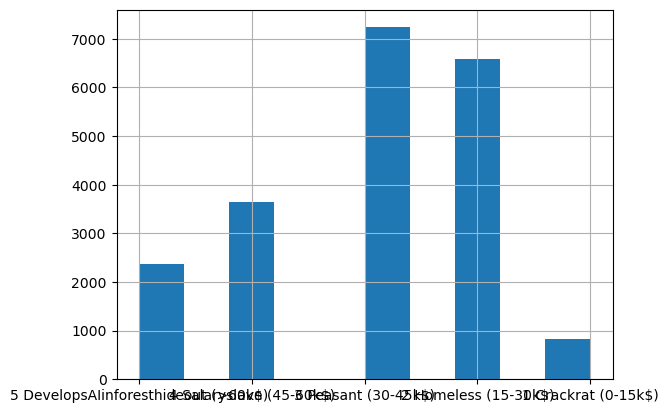

In [7]:
"Stratify our median incomes into income categories"
import numpy as np
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0.,1.5,3.0,4.5,6., np.inf], labels=["1 Crackrat (0-15k$)","2 Homeless (15-30k$)","3 Peasant (30-45k$)","4 Salaryslave (45-60k$)","5 DevelopsAIinforesthideout (>60k$)"])
housing["income_cat"].hist()
# Based on our income categories, we apply a SSS to avoid bias in our small test set
from sklearn.model_selection import StratifiedShuffleSplit
SS_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in SS_split.split(housing,housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

# Overwriting the train-test-split with our stratified data
# TEST_SIZE = 0.2 
train_set, test_set = train_test_split(housing,test_size=TEST_SIZE,random_state=42)

In [8]:
# The proportions of the income_cat groups are defined as the following fractions
total_value_counts = housing["income_cat"].value_counts() / len(housing)
normal_test_value_counts = test_set["income_cat"].value_counts()/ len(test_set)
strat_test_value_counts = strat_test_set["income_cat"].value_counts()/ len(strat_test_set)

# The absolute errors
abs_n_err = (abs((normal_test_value_counts.values)-(total_value_counts.values)))
abs_s_err = (abs((strat_test_value_counts.values)-(total_value_counts.values)))

# Convert the Series object to a DataFrame with appropriate column names
df_comparison = pd.DataFrame({
    "Income Category": total_value_counts.index,
    "Normal Proportion": total_value_counts.values,
    "Test Proportion": normal_test_value_counts.values,
    "Test Proportion Error": abs_n_err,
    "Strat Test Proportion": strat_test_value_counts.values,
    "Strat Test Proportion Error": abs_s_err
})
print(df_comparison)

# After using the stratisfyer category, we shall delete it from our train and test sets to avoid influence on our further procedure
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat",axis=1,inplace=True)

                       Income Category  Normal Proportion  Test Proportion  \
0                  3 Peasant (30-45k$)           0.350581         0.358527   
1                 2 Homeless (15-30k$)           0.318847         0.324370   
2              4 Salaryslave (45-60k$)           0.176308         0.167393   
3  5 DevelopsAIinforesthideout (>60k$)           0.114438         0.109496   
4                  1 Crackrat (0-15k$)           0.039826         0.040213   

   Test Proportion Error  Strat Test Proportion  Strat Test Proportion Error  
0               0.007946               0.350533                     0.000048  
1               0.005523               0.318798                     0.000048  
2               0.008915               0.176357                     0.000048  
3               0.004942               0.114341                     0.000097  
4               0.000388               0.039971                     0.000145  


In [10]:
housing_train = strat_train_set.copy()

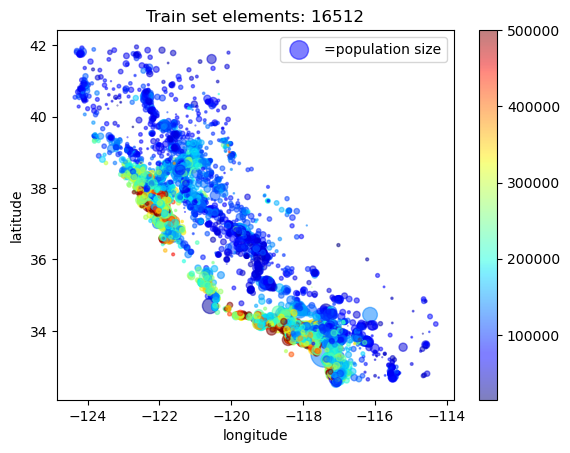

In [11]:
import matplotlib.pyplot as plt

housing_train.plot(kind="scatter", x="longitude",y="latitude",alpha=0.5,
                 s=housing_train["population"]/100,c=housing_train["median_house_value"],
                 cmap=plt.get_cmap("jet"),
                 label="=population size",
                 colorbar=True
                 ) 
# Plotting the districts with alpha=0.1 (transparency) 
# s is the radius of each circle, representing the total population of the district
# c determines the color of each circle
# cmap defines the red to blue scheme
# colorbar displays the color-value correlation
train_set_elements = str(len(housing_train))
plt.title(label=f"Train set elements: {train_set_elements}")
plt.show()

<class 'pandas.core.frame.DataFrame'>
Index: 12 entries, longitude to population_per_household
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 12 non-null     float64
 1   latitude                  12 non-null     float64
 2   housing_median_age        12 non-null     float64
 3   total_rooms               12 non-null     float64
 4   total_bedrooms            12 non-null     float64
 5   population                12 non-null     float64
 6   households                12 non-null     float64
 7   median_income             12 non-null     float64
 8   median_house_value        12 non-null     float64
 9   rooms_per_household       12 non-null     float64
 10  bedrooms_per_room         12 non-null     float64
 11  population_per_household  12 non-null     float64
dtypes: float64(12)
memory usage: 1.5+ KB
None


C:\Users\MaxB2\AppData\Local\Temp\ipykernel_18148\2257250225.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing_train.corr()


<Axes: >

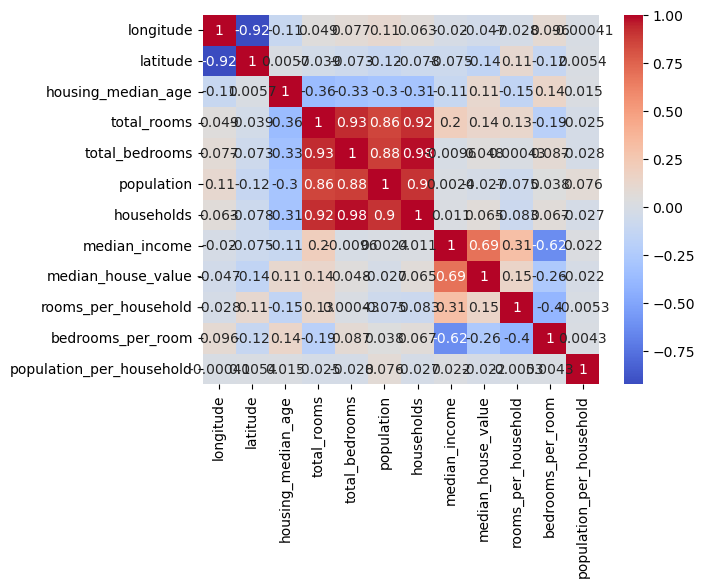

In [45]:
# Searching for useful correlation in the data
corr_matrix = housing_train.corr()
print(corr_matrix.info())
# Create a heatmap using the DataFrame
import seaborn as sns
# create heatmap using Seaborn
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

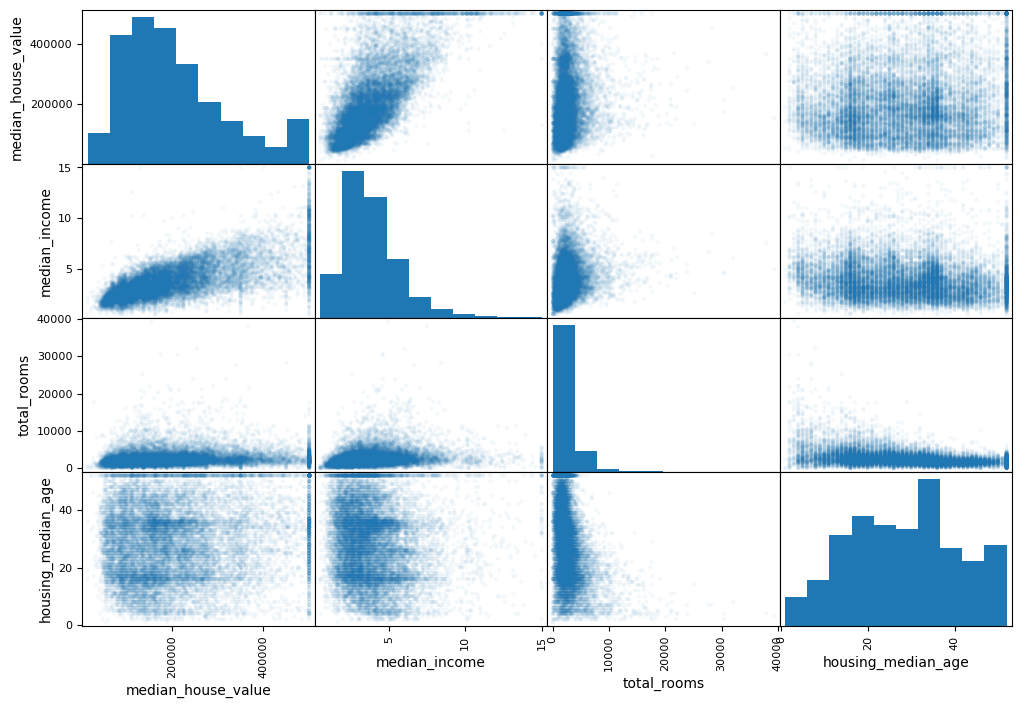

In [13]:
from pandas.plotting import scatter_matrix as ppsm
attributes = ["median_house_value","median_income","total_rooms","housing_median_age"]
ppsm(housing_train[attributes],figsize=(12,8),alpha=0.05)

In [14]:
# Adding some custom properties for more noteworthy metrics
housing_train["rooms_per_household"]=housing_train["total_rooms"]/housing_train["households"]
housing_train["bedrooms_per_room"]=housing_train["total_bedrooms"]/housing_train["total_rooms"]
housing_train["population_per_household"]=housing_train["population"]/housing_train["households"]

In [40]:
"""Checking out some correlations"""
corr_matrixnew = housing_train.corr()
print(corr_matrixnew["median_house_value"].sort_values(ascending=False))

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64


C:\Users\MaxB2\AppData\Local\Temp\ipykernel_18148\3440909222.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrixnew = housing_train.corr()


In [50]:
# Creating numerical trainset for our Simple Imputer AND UselessShitDropper
trainset_num = housing_train.drop("ocean_proximity",axis=1)
# Separating the labels from the train set
trainset_w_features = trainset_num.drop("median_house_value",axis=1)
trainset_w_label = housing_train["median_house_value"].copy()


In [52]:
mask = (abs(trainset_num.corr()["median_house_value"]) < 0.1) & (trainset_num.columns != "median_house_value")
housing_train_wo_bs = trainset_num.drop(trainset_num.columns[mask], axis=1)
housing_train_wo_bs

,latitude,housing_median_age,total_rooms,median_income,median_house_value,rooms_per_household,bedrooms_per_room
12655,38.52,29.0,3873.0,2.1736,72100.0,5.485836,0.205784
15502,33.09,7.0,5320.0,6.3373,279600.0,6.927083,0.160714
2908,35.37,44.0,1618.0,2.8750,82700.0,5.393333,0.191595
14053,32.75,24.0,1877.0,2.2264,112500.0,3.886128,0.276505
20496,34.28,27.0,3536.0,4.4964,238300.0,6.096552,0.182692
...,...,...,...,...,...,...,...
15174,33.03,14.0,6665.0,5.0900,268500.0,6.658342,0.184696
12661,38.51,15.0,7901.0,2.8139,90400.0,5.571932,0.179977
19263,38.44,48.0,707.0,3.1797,140400.0,4.110465,0.234795
19140,38.31,14.0,3155.0,4.1964,258100.0,6.297405,0.183835


In [17]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
imputer.fit(trainset_num) # Fitting the Imputer instance to the data set

XX = imputer.transform(trainset_num)
trainset_num_tr = pd.DataFrame(XX, columns=trainset_num.columns, index=trainset_num.index)

#X = imputer.transform(housing_num)
#housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
#housing_tr.info()
#housing_num.info()

trainset_opcat = trainset_w_features[["ocean_proximity"]]
#trainset_opcat.reshape(-1, 1) # if your data has a single feature or
#print(trainset_opcat) 
#trainset_opcat.reshape(1, -1)
print(trainset_opcat) 
from sklearn.preprocessing import OneHotEncoder
OHE = OneHotEncoder()
housing_cat_1hot = OHE.fit_transform(trainset_opcat)
print(housing_cat_1hot.toarray())

      ocean_proximity
12655          INLAND
15502      NEAR OCEAN
2908           INLAND
14053      NEAR OCEAN
20496       <1H OCEAN
...               ...
15174       <1H OCEAN
12661          INLAND
19263       <1H OCEAN
19140       <1H OCEAN
19773          INLAND

[16512 rows x 1 columns]
[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [29]:
"""Definition of Own Transformers"""
# To add better attributes
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6
class CombinedAttributesAdder(BaseEstimator,TransformerMixin):
    def __init__(self,add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        rooms_per_household = X[:,rooms_ix]/X[:,households_ix]
        population_per_household = X[:,population_ix]/X[:,households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,bedrooms_ix]/X[:,rooms_ix]
            return np.c_[X,rooms_per_household,population_per_household,bedrooms_per_room]
        else:
            return np.c_[X,rooms_per_household,population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)


# To drop useless attributes
# Drop population, total_rooms, total_bedrooms, households, and ISLAND, NEAR BAY,NEAR OCEAN,<1H OCEAN

mask = (abs(trainset_num.corr()["median_house_value"]) < 0.1) & (trainset_num.columns != "median_house_value")
housing_train_wo_bs = trainset_num.drop(trainset_num.columns[mask], axis=1)
housing_train_wo_bs





In [ ]:
# Pipeline for automatic data transformation
# Output is basically all we did before, but faster
# Tranforms all numerical values into the Standard-Derivation form
# Tranforms all categorical values into a OneHot-Matrix
# type(housing_prepared) = numpy.ndarray !

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("attribs_adder", CombinedAttributesAdder()),
    ("std_scaler",StandardScaler())    
])
housing_num_tr = num_pipeline.fit_transform(trainset_num)

from sklearn.compose import ColumnTransformer

num_attribs = list(trainset_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num",num_pipeline,num_attribs),
    ("cat", OneHotEncoder(),cat_attribs)
])
housing_prepared = full_pipeline.fit_transform(trainset_w_features)

In [ ]:
"""Model Training and Testing on TRAINING DATA"""
"""No1 - Linear Regression"""
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, trainset_w_label)
some_data = trainset_w_features.iloc[:5]
some_labels = trainset_w_label.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data) # Applies the "fast tranform" to our data
rndd_prdctn = [round(num, 0) for num in lin_reg.predict(some_data_prepared)]

# For big data sets, we should test our code with a smaller batch of the train data
print("===For 5 Datapoints===")
print("Prediction for 5 data points: ", rndd_prdctn)
print("True Values for 5 data points: ", list(some_labels))
from sklearn.metrics import mean_squared_error as mse
lin_reg_mse = np.sqrt(mse(rndd_prdctn, some_labels))
print("MSE for 5 data points: ", lin_reg_mse)

# Now the whole dataset w/ Linear Regression
full_rndd_prdctn = [round(pred,0) for pred in lin_reg.predict(housing_prepared)]
print("===For the Whole Set===")
print("Prediction for whole set: ", full_rndd_prdctn)
print("True Values for whole set: ", list(trainset_w_label))
full_lin_reg_mse = np.sqrt(mse(full_rndd_prdctn, trainset_w_label))
print("MSE for whole set: ", full_lin_reg_mse)
print("===Summary===")
print("Relative difference of mean error and average housing price: ", round((full_lin_reg_mse*100/trainset_w_label.mean()),1), "%")
# The current error is 33.2 % of the average house price, this is nuts, and too much for a good prediction
# Experts are usually capable of predicting the house price with 20% accuracy, so we should work towards that

"""Cross Validation of the LinReg Century Error"""
from sklearn.model_selection import cross_val_score as cvs
scores2 = cvs(lin_reg,housing_prepared,trainset_w_label,scoring="neg_mean_squared_error", cv=10)
print(list(int(round(num,0)) for num in np.sqrt(-scores2)))

In [ ]:
"""No2 - Decision Tree"""
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor()
dtr.fit(housing_prepared, trainset_w_label)
dtr.predict(housing_prepared)
print("MSE for the DTR model: ",np.sqrt(mse(dtr.predict(housing_prepared),trainset_w_label)))
# MSE for the DTR model:  0.0
# This is a sign of overfitting hardcore

"""Cross Validation of the DTR Fraud"""
# Scikit cross_val_score separates our (training) data into chunks for in-between fit check

tree_scores = cvs(dtr,housing_prepared,trainset_w_label,scoring="neg_mean_squared_error", cv=10) 
tree_rmse_scores = np.sqrt(-tree_scores)

def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard Derivation: ",(scores.std()))

display_scores(tree_rmse_scores)
# [72628, 71478, 68834, 72742, 69408, 76213, 69743, 73693, 68960, 67938]
# As we see, this is even worse than our linear regression

In [ ]:
"""No3 - Random Forest Regressor"""
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
rfr.fit(housing_prepared, trainset_w_label)
print("Checkpoint: Model fitting done")
rfr_predict = rfr.predict(housing_prepared)
print("Checkpoint: Predictions done")

forest_scores = cvs(rfr,housing_prepared,trainset_w_label,scoring="neg_mean_squared_error", cv=10) 
forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)
print("MSE Calc: ", np.sqrt(mse(rfr_predict,trainset_w_label)))
# took over 3 minutes
# The RFR is the best we have even though the error is quite high


In [ ]:
"""Model Optimization"""
"""Systematic Search For Hyperparameters: Grid Search"""
from sklearn.model_selection import GridSearchCV as GS
param_grid = [
    {"n_estimators":[10,30],"max_features":[8,12]},
    {"bootstrap":[False],"n_estimators":[10,30],"max_features":[8,12]}
]

grid_search = GS(rfr,
                 param_grid,
                 cv=3,
                 scoring="neg_mean_squared_error",
                 return_train_score=True
)

grid_search.fit(housing_prepared,trainset_w_label) # Takes a while >3min
best_parameters = grid_search.best_params_
print("Best Par: ", best_parameters)
best_estimator = grid_search.best_estimator_
print("Best Est: ",best_estimator)

In [ ]:
"""Grid Search Results"""
cvres = grid_search.cv_results_
for mean_score, params in zip (cvres["mean_test_score"],cvres["params"]):
    print(np.sqrt(-mean_score),params)

In [ ]:
"""Feature Importance"""
feature_importances = grid_search.best_estimator_.feature_importances_
print("Default : ", feature_importances)
extra_attribs = ["rooms_per_hhld","population_per_hhld","bedrooms_per_room"]
cat_encoder1 = full_pipeline.named_transformers_["cat"]
cat_1hot_attribs = list(cat_encoder1.categories_[0])
attributes1 = num_attribs + extra_attribs + cat_1hot_attribs
print("")

resultz = sorted(zip(feature_importances, attributes1), reverse=True)
for importance, attribute in resultz:
    print(f"Importance: {importance}, Attribute: {attribute}")

# We can probably drop population, total_rooms, total_bedrooms, households, and ISLAND, NEAR BAY,NEAR OCEAN,<1H OCEAN

In [ ]:
"""Evaluation on Test Data"""
final_model = grid_search.best_estimator_
print("Model used: ", final_model)

X_test = strat_test_set.drop("median_house_value",axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

y_pred = pd.Series(final_model.predict(X_test_prepared))

final_rmse = np.sqrt(mse(y_test, y_pred))
print("RMSE :",final_rmse)


In [ ]:
from scipy import stats
confidence = 0.95
y_pred1 = y_pred.reset_index(drop=True)
y_test1 = y_test.reset_index(drop=True)
squared_errors = (y_pred1 - y_test1) ** 2
interval = np.sqrt(stats.t.interval(confidence,len(squared_errors)-1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

"The confidence level specified in the function is 0.95,"
print(f"There is a 95% probability that the true mean squared error is between {round(interval[0],0)} and {round(interval[1],0)}.")
interval
